In [2]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons,make_classification,make_regression,make_circles
import sys
from mpl_toolkits.mplot3d import Axes3D 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

np.random.seed(23)
np.set_printoptions(precision=3,suppress=True)

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1./(np.sqrt(s+1e-2))+1e-8), u.T), W)

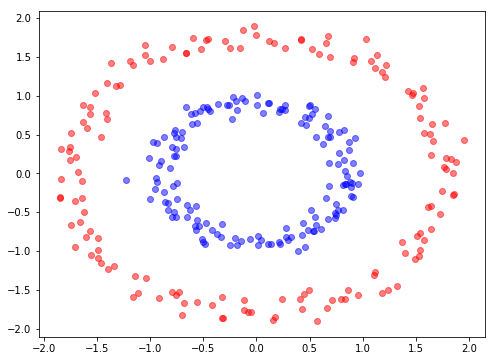

In [119]:
# See the data 
X, y = make_moons(n_samples=300, noise=0.02)
X, y = make_circles(n_samples=300, noise=0.05,factor=0.5)
# X = X @ np.array([
#     [1,0],
#     [1,2]
# ])
# X,y = make_regression(n_samples=400, n_features=1,noise=5); X = np.concatenate((X,y[:,None]),1) 

# ======== WE ARE CENTERING AND STD =======
X[:,1] = -X[:,1]
X = (X - X.mean(0))/X.std(0)
# ======== WE ARE CENTERING AND STD =======

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
# plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.show()

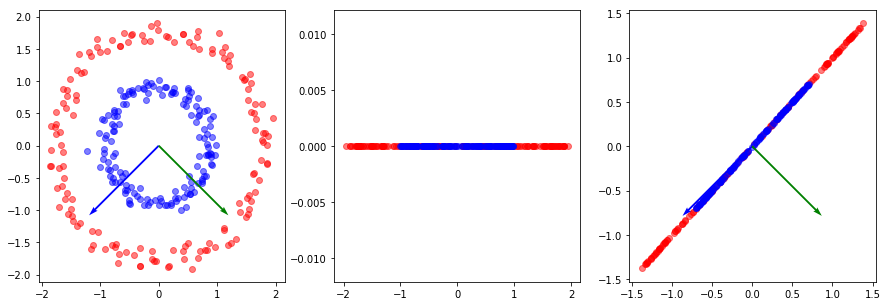

In [120]:
# traditional PCA

# 1. projection
cov = X.T @ X / X.shape[1]
evalue,evector = np.linalg.eig(cov)
idx = np.argsort(evalue)[::-1]
evecs = evector[:,idx]
projected = X @ evecs[:,0]
recovered = projected[:,None] @ evecs[:,0][:,None].T

# 2. recover
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
# plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
# plt.scatter(projected,np.zeros(len(projected)), color='red', alpha=0.5)
plt.scatter(projected[y==0], np.zeros((len(projected)//2)), color='red', alpha=0.5)
plt.scatter(projected[y==1], np.zeros((len(projected)//2)), color='blue', alpha=0.5)


plt.subplot(1, 3, 3)
# plt.scatter(recovered[:, 0], recovered[:,1], color='red', alpha=0.5)
plt.scatter(recovered[y==0, 0], recovered[y==0, 1], color='red', alpha=0.5)
plt.scatter(recovered[y==1, 0], recovered[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

In [101]:
#  act functions 
def g(x) :     return np.arctan(x)
def gg(x):     return np.tan(x)
def g_grad(x): return 1/(1+x**2)
def gg_grad(x):return 1/(np.cos(x)*2+1e-8)

Iter :  0  Loss:  4.301841727079783
Iter :  200  Loss:  6.640138129844994
Iter :  400  Loss:  6.640138129879508
Iter :  600  Loss:  6.640138129913978
Iter :  800  Loss:  6.6401381299485065


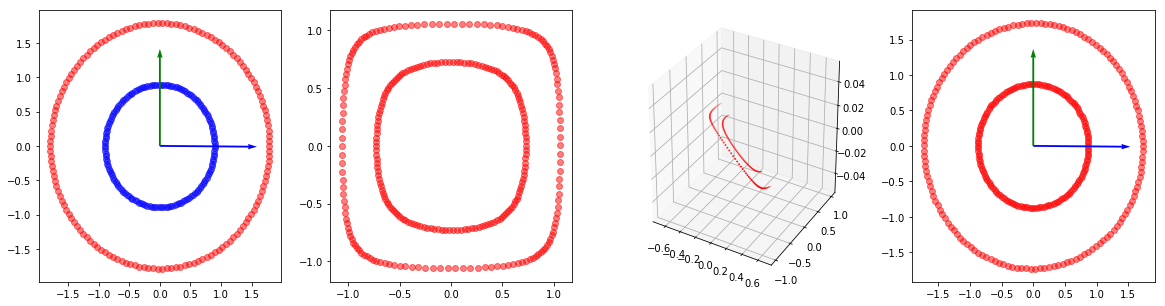

In [84]:
# with all scale
w1 = np.random.randn(2,2)
w2 = np.random.randn(2,3)

mini_batch_size = 150
a = np.ones((2))
b = np.ones((2))
c = np.zeros((2))

w1 = _sym_decorrelation(w1)
w2 = _sym_decorrelation(w2)

temp_X = np.copy(X)
for iter in range(1000):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    
    for mini_batch in range(0,len(X),mini_batch_size):
        current_batch = temp_X[mini_batch:mini_batch+mini_batch_size]
        
        layer1 = current_batch @ w1
        layer1a= a*g(b*layer1)+c
        layer2 = layer1a       @ w2
        loss   = w2.T @ layer1a.T @ layer1a @ w2
        
        grad2 = -layer1a.T @ layer1a @ w2 
        grad1a= -layer1a@w2@w2.T
        grada = grad1a*g(b*layer1)
        gradb = grad1a*a*g_grad(b*layer1)*layer1
        gradc = grad1a
        grad1 = current_batch.T @(grad1a*a*g_grad(b*layer1)*b)

        w2 = w2 - 0.00000000000001* grad2
        a = a -   0.00000000000001* grada.mean(0)
        b = b -   0.00000000000001* gradb.mean(0)
        c = c -   0.00000000000001* gradc.mean(0)
        w1 = w1 - 0.00000000000001* grad1
        
        w1 = _sym_decorrelation(w1)
        w2 = _sym_decorrelation(w2)
        cum_loss      = cum_loss + loss.mean()
        
    if iter%200==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = (a*g(b*(X @ w1))+c) @ w2
recover_mine   = gg((projected_mine @ w2.T)/b-c)/a @ w1.T

plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 4, 2)
one_layer_project = (a*g(b*(X @ w1))+c)
plt.scatter(one_layer_project[:, 0], one_layer_project[:,1], color='red', alpha=0.5)

plt.subplot(1, 4, 3,projection='3d')
plt.scatter(projected_mine[:,0],projected_mine[:,1],projected_mine[:,2], color='red')

plt.subplot(1, 4, 4)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

In [75]:
# view 3D
trace1 = go.Scatter3d(x=projected_mine[:,0],y=projected_mine[:,1],z=projected_mine[:,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1]
fig  = go.Figure(data=data)
iplot(fig)

IndexError: index 1 is out of bounds for axis 1 with size 1

Iter :  0  Loss:  116.4255591220495
Iter :  200  Loss:  160.46603386168877
Iter :  400  Loss:  184.68891516798905
Iter :  600  Loss:  197.66967318299757
Iter :  800  Loss:  206.4599667083288
Iter :  1000  Loss:  213.98235122620815
Iter :  1200  Loss:  221.21242961894856
Iter :  1400  Loss:  228.46382078611808
Iter :  1600  Loss:  235.84779400234828
Iter :  1800  Loss:  243.4199648463948
Iter :  2000  Loss:  251.21681725790006
Iter :  2200  Loss:  259.2732248805342
Iter :  2400  Loss:  267.6157959817813
Iter :  2600  Loss:  276.27360371130345
Iter :  2800  Loss:  285.27169209480485
Iter :  3000  Loss:  294.6375276332886
Iter :  3200  Loss:  304.3946729257385
Iter :  3400  Loss:  314.5695501506609
Iter :  3600  Loss:  325.186954061889
Iter :  3800  Loss:  336.27481184644387
Iter :  4000  Loss:  347.85981264461606
Iter :  4200  Loss:  359.969279087736
Iter :  4400  Loss:  372.635468943759
Iter :  4600  Loss:  385.8918120601152
Iter :  4800  Loss:  399.76962437271226


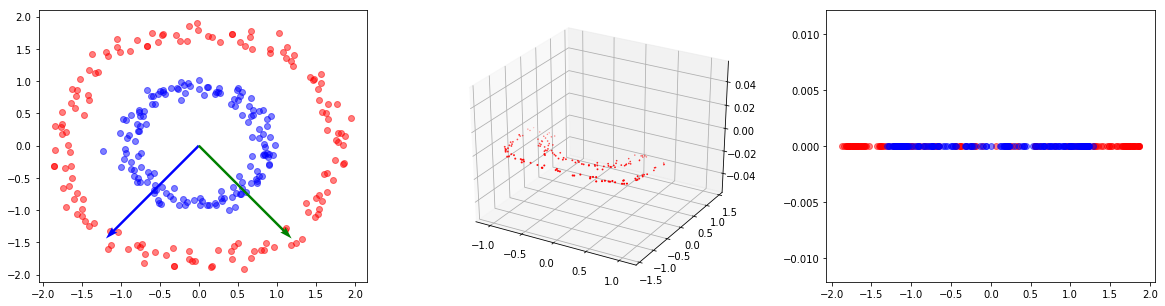

In [122]:
# with all scale
expand_dim = 3
w1 = np.random.randn(2,expand_dim)
w2 = np.random.randn(expand_dim,1)

a = np.ones(expand_dim)
b = np.ones(expand_dim)
c = np.zeros(expand_dim)

w1 = _sym_decorrelation(w1)
w2 = w2/(np.sqrt(np.sum(w2**2)))

temp_X = np.copy(X)
mini_batch_size = 10
for iter in range(5000):
    cum_loss = 0; temp_X   = shuffle(temp_X)
    
    for mini_batch in range(0,len(X),mini_batch_size):
        current_batch = temp_X[mini_batch:mini_batch+mini_batch_size]
        
        layer1 = current_batch @ w1
        layer1a= a*g(b*layer1)+c
        layer2 = layer1a       @ w2
        loss   = w2.T @ layer1a.T @ layer1a @ w2
        
        grad2 = -layer1a.T @ layer1a @ w2 
        grad1a= -layer1a@w2@w2.T
        grada = grad1a*g(b*layer1)
        gradb = grad1a*a*g_grad(b*layer1)*layer1
        gradc = grad1a
        grad1 = current_batch.T @(grad1a*a*g_grad(b*layer1)*b) - current_batch.T @ current_batch @ w1 

        w2 = w2 - 0.000009 * grad2
        a = a -   0.000005 * grada.mean(0)
        b = b -   0.000005 * gradb.mean(0)
        c = c -   0.000005 * gradc.mean(0)
        w1 = w1 - 0.000009 * grad1
        
        w1 = _sym_decorrelation(w1)
        w2 = w2/(np.sqrt(np.sum(w2**2)))
        cum_loss      = cum_loss + loss.mean()
        
    if iter%200==0:print('Iter : ',iter," Loss: ",cum_loss)

# projection
projected_mine = (a*g(b*(X @ w1))+c) @ w2

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
# plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2,projection='3d')
one_layer_project = (a*g(b*(X @ w1))+c)
plt.scatter(one_layer_project[:,0],one_layer_project[:,1],one_layer_project[:,2], color='red')

plt.subplot(1, 3, 3)
# plt.scatter(projected_mine, np.zeros(len(projected_mine) ), color='red', alpha=0.5)
plt.scatter(projected_mine[y==0], np.zeros((len(projected_mine)//2)), color='red', alpha=0.5)
plt.scatter(projected_mine[y==1], np.zeros((len(projected_mine)//2)), color='blue', alpha=0.5)

plt.show()

trace1 = go.Scatter3d(
    x=one_layer_project[y==0,0],
    y=one_layer_project[y==0,1],
    z=one_layer_project[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)

trace2 = go.Scatter3d(
    x=one_layer_project[y==1,0],
    y=one_layer_project[y==1,1],
    z=one_layer_project[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

In [715]:
# whiten
temp = np.random.randn(2,2)
temp2= _sym_decorrelation(temp)
print(temp)
print(np.sqrt(np.sum(temp**2,0)))
print(temp2)
print(np.sqrt(np.sum(temp2**2,0)))

[[-0.20184052  1.04537128]
 [ 0.53816197  0.81211867]]
[0.57476769 1.32375898]
[[-0.53924154  0.84215115]
 [ 0.84215115  0.53924154]]
[1. 1.]


In [706]:
# gradient
temp = np.random.randn(2,1)
print((np.eye(2)+X.T@X)@temp)
print(temp+X.T@X@temp)
print(X.T@X@temp)

[[-331.01649274]
 [ 330.76155127]]
[[-331.01649274]
 [ 330.76155127]]
[[-330.52681434]
 [ 330.4243461 ]]


In [705]:
# trace
temp = np.random.uniform(size=(5,5))
print(temp)
evalue,evector = np.linalg.eigh(temp)
print(np.diag(temp).sum())
print(evalue.sum())

[[0.59957073 0.4179     0.33564758 0.47885035 0.19466667]
 [0.97630966 0.79208879 0.5297333  0.8280434  0.59174909]
 [0.69528467 0.71563046 0.4198738  0.75446309 0.57951776]
 [0.19209108 0.28379276 0.26153899 0.28961355 0.15620311]
 [0.5442491  0.94424172 0.60280994 0.1614653  0.44792688]]
2.5490737389147675
2.549073738914767


<img src="https://i.imgur.com/Isv9zzD.png" >

# Reference 
1. results, P., & Rieble, N. (2016). PCA in numpy and sklearn produces different results. Cross Validated. Retrieved 9 April 2019, from https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results
2. Python, H., & Eunice, J. (2017). How to make two plots side-by-side using Python. Stack Overflow. Retrieved 9 April 2019, from https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python
3. The Theorem that the Sum of the Eigenvalues of a Matrix is Equal to its Trace . (2019). Applet-magic.com. Retrieved 9 April 2019, from http://www.applet-magic.com/eigenvaluestrace.htm
4. 